
## TD($\lambda$) - Discrete time

TD(n) provides a way to get an estimate that's a compromise between the full Monte Carlo estimate and 1-step TD method. TD($\lambda$) is a different kind of compromise: it's a weighted average of the n-step return estimates for all values of n (from 1 to the full episode length, or some max number of steps). Empirically it tends to work better than using any one of the n-step estimates.

$$\delta_t = (1-\lambda )\sum_{n=1}^N \lambda^{n-1} G^{(n)}_t - V(s_t) $$

where $G^{(n)}_t = R_t + \gamma R_{t+1} + \dots + \gamma^{n-1} R_{t+n-1} + \gamma^n V(s_{t+n})$ is the n step return, and $0 \leq \lambda \leq 1$ is the trace decay parameter. Higher values lead to longer lasting traces (a larger proportion of credit from a reward can be given to more distant states).

## Something like TD($\lambda$) in continuous time
### Update past by integrating over window size: TD($\lambda$)
Let's assume we are using the continuous version of TD(n) to get the deltas/TD error estimates. The return will be a function of the length of the time window it is computed over, $G_t(\theta)$. Recall from the TD($\theta$) notebook that this is given by
\begin{align} 
    \delta^{(\theta)}(t) = \left ( \int_{0}^{1} \gamma^{\theta(1 - \tau)} \mathbf{P}^{q_r}(\tau) d\tau \right ) \mathbf{m}_{R}(t) + \gamma^{\theta} V(t) - \mathbf{P}^{q_v}(1)\mathbf{m}_{V}(t) \\
    \rightarrow G_t(\theta)= \left ( \int_{0}^{1} \gamma^{\theta(1 - \tau)} \mathbf{P}^{q_r}(\tau) d\tau \right ) \mathbf{m}_{R}(t) + \gamma^{\theta} \mathbf{P}^{q_v}(0)\mathbf{m}_{V}(t)
 \end{align}

To get something like TD($\lambda$) we could integrate over returns from $G_t(0)$ to $G_t(\theta)$ -- i.e., we are updating our past value estimate $V(s_{t-\theta})$ using the entire window of value estimates since then. Rather than using discrete exponential smoothing with $\lambda$ we'll use exponential decay $e^{-\lambda\theta}$:

\begin{align}
\delta^{(\lambda)}_t &= \int_{\phi=0}^{1} e^{-\lambda \phi \theta} G_{t-\phi\theta}(\phi\theta) d\phi - V(t - \theta)\\
&=   \int_{\phi=0}^{1} e^{-\lambda \phi \theta} \left ( \int_{\tau=\phi}^{1} \gamma^{\theta(1 - \tau)} \mathbf{P}^{q_r}(\tau) d\tau   \mathbf{m}_{R}(t) + \gamma^{\phi\theta}  \mathbf{P}^{q_v}(\phi)\mathbf{m}_{V}(t)  \right ) d\phi - \mathbf{P}^{q_v}(1)\mathbf{m}_{V}(t) \\
&= \left ( \int_{\phi=0}^{1} \int_{\tau=\phi}^{1}  e^{-\lambda \phi \theta}  \gamma^{\theta(1 - \tau)} \mathbf{P}^{q_r}(\tau) d\tau \right )   \mathbf{m}_{R}(t)  \\
& +\left ( \int_{\phi=0}^{1} e^{-\lambda \phi \theta} \gamma^{\phi\theta}  \mathbf{P}^{q_v}(\phi)d\phi - \mathbf{P}^{q_v}(1) \right ) \mathbf{m}_{V}(t)   
\end{align}

All we're doing is appling linear transformations to our LMU memories. These transforms (e.g., $\int_{\phi=0}^{1} e^{-\lambda \phi \theta} \gamma^{\phi\theta}  \mathbf{P}^{q_v}(\phi)d\phi$) involve integrals but these are fixed and can be precomputed. The resulting model is structurely the same as the TD(0) or TD($\theta$) rules we've defined in the other notebooks -- just different transform matrices are applied to the LMU memories. 

## Example
Here's a simple example problem. An agent travels around a circle and gets a reward when it is near some particular spot. Our network should learn a value function that anticipates this reward.

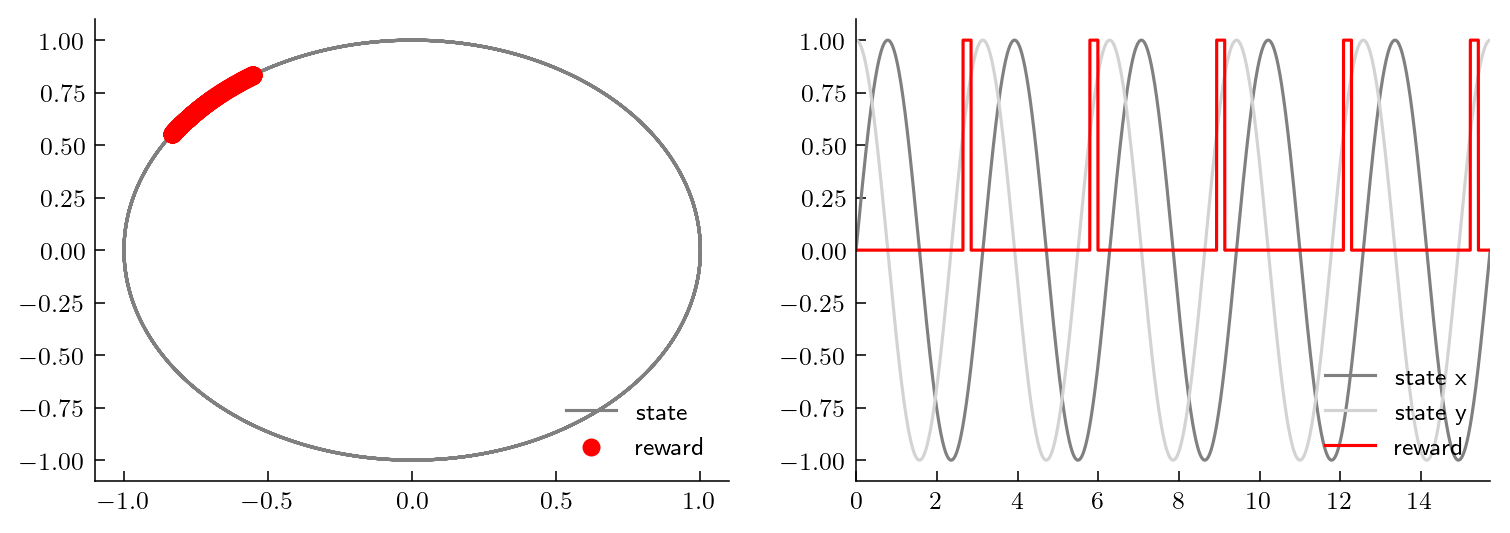

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import rl.figure_utils as utils
import nengo
from rl.networks import ValueCritic
from rl.utils import sparsity_to_x_intercept

## Very simple RL problem for testing: Go around a circle and get reward at particular spots
# The state is (x,y) position 
T=np.pi*5
dt = 0.001
timesteps = np.arange(0,T,dt)
def sim_fun(t):
    return np.stack([np.sin(t*2), np.cos(t*2)]).T
sim_path = sim_fun(timesteps)

def reward_fun(t):
    if isinstance(t, np.ndarray):
        rewards = np.zeros(len(t))
        rewards[np.sqrt(np.sum((sim_fun(t) - np.array([-0.707,0.707]))**2,axis=1)) < 0.2] = 1
    else:
        rewards = 1 if (np.sqrt(np.sum((sim_fun(t) - np.array([-0.707,0.707]))**2)) < 0.2) else 0
    return rewards

rewards = reward_fun(timesteps)
    
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.plot(sim_path[:,0],sim_path[:,1], label='state',zorder=1,color='grey')
plt.scatter(sim_path[rewards>0,0], sim_path[rewards>0,1], label='reward',s=30,zorder=2, color='red')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(timesteps,sim_path[:,0], label='state x',color='grey')
plt.plot(timesteps,sim_path[:,1], label='state y',color='lightgrey')
plt.plot(timesteps,rewards, label='reward', color='red')
plt.xlim([0,T])
plt.legend(loc='lower right')

Baseline for comparsion:

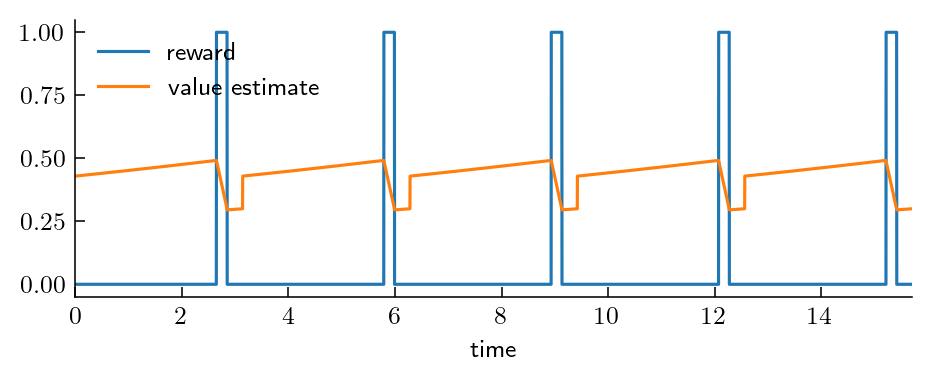

In [2]:
# solution via computing returns
discount  =0.95
returns = [dt*np.sum(discount**(dt*np.arange(len(rewards)-i))*rewards[i:]) for i in range(len(rewards))]

n_period = int(np.pi/dt)
vals_direct=[np.mean([returns[j*n_period + i] for j in range(5)]) for i in range(n_period)]
repeated_vals = np.tile(vals_direct,int(T/np.pi))

plt.figure(figsize=(5.4,1.8))
plt.plot(timesteps,rewards, label='reward')
plt.plot(timesteps[:len(repeated_vals)],repeated_vals, label='value estimate')
plt.xlim([0,T])
plt.xlabel('time')
plt.legend()

In [3]:

T=np.pi*10

n_neurons_state=400
n_neurons_value=400
discount = 0.95
theta = 1.5
lambd=1-0.95

q_a = 8
q_r = 8
q_v = 8



In [4]:

model = nengo.Network(seed=0)
with model:
    state = nengo.Node(sim_fun)
    reward = nengo.Node(reward_fun)

    VL = ValueCritic(n_neurons_state,n_neurons_value, theta, 2, 
                     discount, q_a, q_r, q_v,'TDlambda',
                     T_test=0.8*T,learning_rate=1e-4,lambd=lambd,
                     intercepts=nengo.dists.Choice([sparsity_to_x_intercept(2, 0.1)]))
    nengo.Connection(state, VL.state_input, synapse=None)
    nengo.Connection(reward, VL.reward_input, synapse=None)
    
    V_p = nengo.Probe(VL.value, synapse=.05)
    Vmem_p = nengo.Probe(VL.value_memory, synapse=None)
    r_p = nengo.Probe(reward, synapse=None)
    rmem_p = nengo.Probe(VL.reward_memory, synapse=None)
    stateact_p = nengo.Probe(VL.state.neurons, synapse=0.005)
    stateactmem_p = nengo.Probe(VL.state_memory, synapse=None)
    er_p = nengo.Probe(VL.rule, "error", synapse=None)
    

with nengo.Simulator(model,dt=dt) as sim:
    sim.run(T)
ts = sim.trange() 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 0, 'Time (s)')

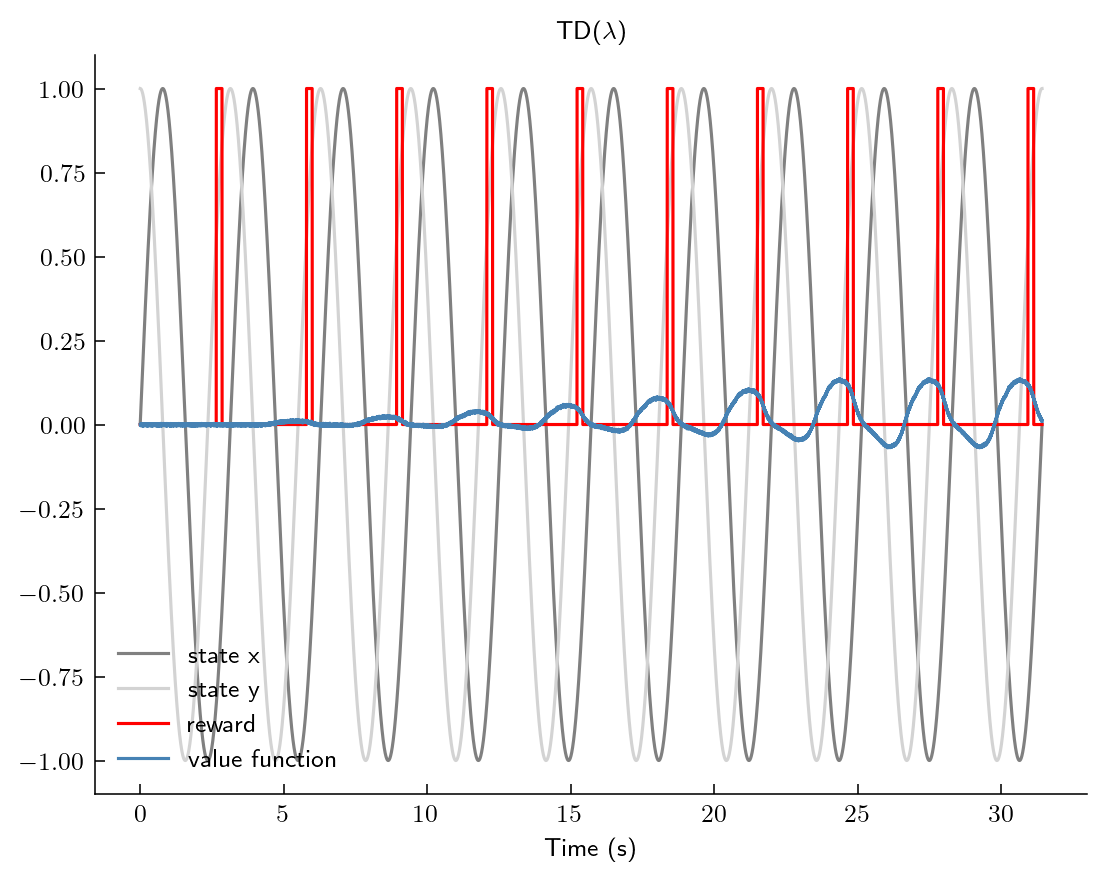

In [5]:
sim_path = sim_fun(ts)
rewards = reward_fun(ts)

plt.figure()
plt.plot(ts,sim_path[:,0], label='state x',color='grey')
plt.plot(ts,sim_path[:,1], label='state y',color='lightgrey')
plt.plot(ts,rewards, label='reward', color='red')
plt.plot(ts, sim.data[V_p], color='steelblue', label='value function')
plt.legend()
plt.title('TD($\\lambda$)')
plt.xlabel('Time (s)')
# learning is turned off after 9 seconds

Text(0.5, 0, 'Time (s)')

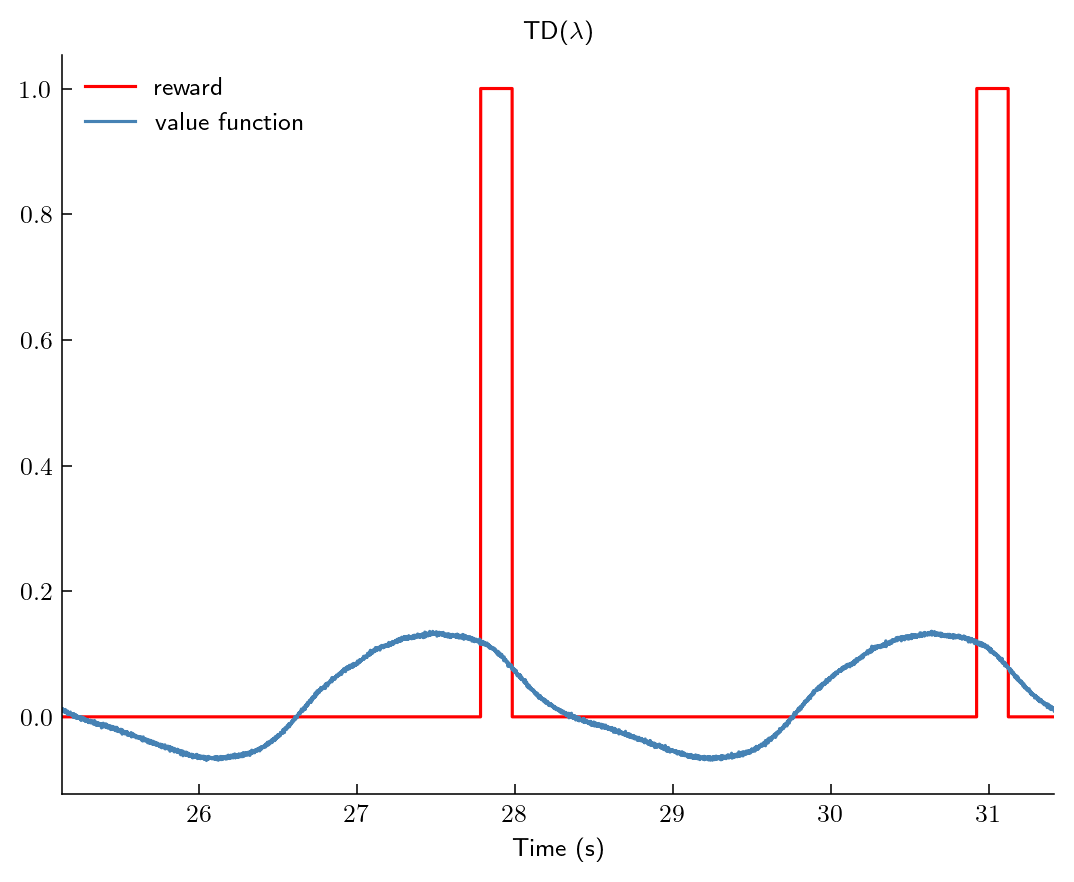

In [6]:
plt.figure()
plt.plot(ts,rewards, label='reward', color='red')
plt.plot(ts, sim.data[V_p], color='steelblue', label='value function')
plt.xlim([0.8*T,T])
plt.legend()
plt.title('TD($\\lambda$)')
plt.xlabel('Time (s)')

### Use window to integrate over updates: TD($\Lambda$)
There is another way we can integrate over window size to obtain something like TD($\lambda$). Rather than update $V(s_{t-\theta})$ using windows of size 0 to $\theta$, we could, at every timestep, update $V(s_{t-\theta})$ to $V(s_{t})$ with the appropriate window lengths -- i.e., update all past estimates in memory. Over time, this means that all past estimates will get updates computed using varying window sizes -- like TD($\lambda$) -- but without the explicit exponential weighting. Updates recieved at later times (with larger window sizes) may partially 'overwrite' old updates, giving us a sort of temporal weighting. Let's call this rule TD($\Lambda$).

This will requrie integrating over the neural activity memories:

\begin{align} 
     \Delta d &= \kappa \left ( \int_{\phi=0}^{1} \delta^{(\phi\theta)}(t) \mathbf{P}^{q_a}(\phi) \right ) \mathbf{m}_{a}(t)
\\
&= \left [  \left ( \int_{\phi=0}^{1} \int_{\tau = 0}^{\phi} \gamma^{\theta(\phi - \tau)} \mathbf{P}^{q_r}(\tau)^T   \mathbf{P}^{q_a}(\phi) d\tau  d\phi  \right )  \mathbf{m}_{R}(t)
 +  \left ( \int_{\phi=0}^{1}\gamma^{\phi\theta} \mathbf{P}^{q_a}(\phi) d\phi \right ) V(t) \right . \\
&\quad\quad - \left . \left (   \int_{\phi=0}^{1}\mathbf{P}^{q_v}(\phi)^T \mathbf{P}^{q_a}(\phi) d\phi \right ) \mathbf{m}_{V}(t) \right ]\mathbf{m}_{a}(t)
 \end{align}
 
 So we can apply the above transformations to the value function, value LMU, and reward LMU via their decoders. Then modify the PES leanring rule to compute $\kappa  \mathbf{m}_{a_j}(t)$ times its input to modify decoders.



In [9]:
from rl.networks.nengo_online_critics import get_critic_transforms
activity_lmu_transform, reward_lmu_transform, value_lmu_transform = get_critic_transforms(
    'TDLambda', discount, n_neurons_state, theta,
     q_a=q_a, q_r = q_r, q_v=q_v, lambd=lambd, epsabs=1e-2)

In [10]:
lambd = 0.95 # actually not used
model = nengo.Network()
with model:
    state = nengo.Node(sim_fun)
    reward = nengo.Node(reward_fun)

    VL = ValueCritic(n_neurons_state,n_neurons_value, theta, 2, discount, q_a, q_r, q_v,'TDLambda',
                     T_test=0.8*T,learning_rate=1e-5,lambd=lambd,
                     intercepts=nengo.dists.Choice([sparsity_to_x_intercept(2, 0.1)]),
                    activity_lmu_transform=activity_lmu_transform,
                     reward_lmu_transform=reward_lmu_transform,
                     value_lmu_transform=value_lmu_transform)
    nengo.Connection(state, VL.state_input, synapse=None)
    nengo.Connection(reward, VL.reward_input, synapse=None)
    
    V_p = nengo.Probe(VL.value, synapse=.05)
    # Vmem_p = nengo.Probe(VL.value_memory, synapse=None)
    # r_p = nengo.Probe(reward, synapse=None)
    # rmem_p = nengo.Probe(VL.reward_memory, synapse=None)
    # stateact_p = nengo.Probe(VL.state.neurons, synapse=0.005)
    # stateactmem_p = nengo.Probe(VL.state_memory, synapse=None)
    # er_p = nengo.Probe(VL.rule, "error", synapse=None)
    

with nengo.Simulator(model,dt=dt) as sim:
    sim.run(T)
ts = sim.trange()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 0, 'Time (s)')

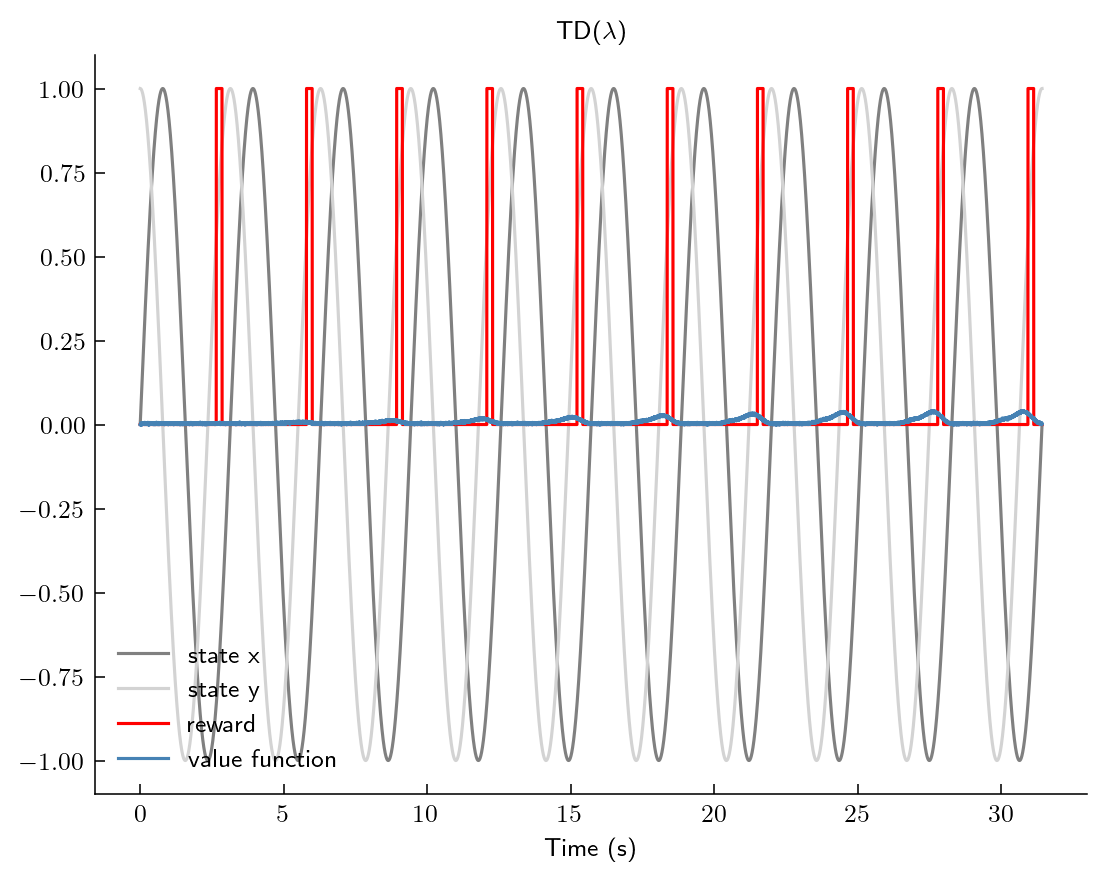

In [11]:
sim_path = sim_fun(ts)
rewards = reward_fun(ts)

plt.figure()
plt.plot(ts,sim_path[:,0], label='state x',color='grey')
plt.plot(ts,sim_path[:,1], label='state y',color='lightgrey')
plt.plot(ts,rewards, label='reward', color='red')
plt.plot(ts, sim.data[V_p], color='steelblue', label='value function')
plt.legend()
plt.title('TD($\\lambda$)')
plt.xlabel('Time (s)')